In [131]:
import time

import geopandas as gpd
import numpy as np
import pandas as pd

from shapely import Point, Polygon, MultiPolygon
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
# Points - drop duplicates

In [133]:
sample_points = [
    [0, 0],
    [0, 1],
    [0, 3],
    [3, 1],
    [0, 1]
]

sample_points = [Point(sp) for sp in sample_points]

In [134]:
gs = gpd.GeoSeries(sample_points)

In [135]:
gs

0    POINT (0.00000 0.00000)
1    POINT (0.00000 1.00000)
2    POINT (0.00000 3.00000)
3    POINT (3.00000 1.00000)
4    POINT (0.00000 1.00000)
dtype: geometry

In [136]:
gs.drop_duplicates()

0    POINT (0.00000 0.00000)
1    POINT (0.00000 1.00000)
2    POINT (0.00000 3.00000)
3    POINT (3.00000 1.00000)
dtype: geometry

In [137]:
# Polygon - drop duplicates

In [138]:
polygon_a = Polygon([(0, 1), (2, 3), (2, 6), (0, 1)])
polygon_b = Polygon([(2, 3), (2, 6), (0, 1), (2, 3)])

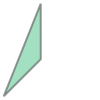

In [139]:
polygon_a

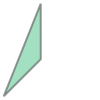

In [140]:
polygon_b

In [141]:
gs = gpd.GeoSeries(data=[polygon_a, polygon_b])

In [142]:
len(gs.drop_duplicates())

2

In [143]:
# Solution 1: use Shapely to detect the same geometries

In [144]:
def drop_duplicated_geometries(geoseries: gpd.GeoSeries):
    """
    Function drops duplicated geometries from a geoseries. It works as follow:
    
        1. Take record from the dataset. Check it's index against list of indexes-to-skip.
        If it's not there then move to the next step.
        2. Store record's index in the list of processed indexes (to re-create geoseries without duplicates)
        and in the list of indexes-to-skip.
        3. Compare this record to all other records. If any of them is a duplicate then store its index in
        the indexes-to-skip.
        4. If all records are checked then re-create dataframe without duplicates based on the list
        of processed indexes.
        
    INPUT:
    
    :param geoseries: (gpd.GeoSeries)
    
    OUTPUT:
    
    :returns: (gpd.Geoseries)
    """
    
    indexes_to_skip = []
    processed_indexes = []
    
    for index, geom in geoseries.items():
        if index not in indexes_to_skip:
            processed_indexes.append(index)
            indexes_to_skip.append(index)
            for other_index, other_geom in geoseries.items():
                if other_index in indexes_to_skip:
                    pass
                else:
                    if geom.equals(other_geom):
                        indexes_to_skip.append(other_index)
                    else:
                        pass
    output_gs = geoseries[processed_indexes].copy()
    return output_gs

In [145]:
drop_duplicated_geometries(gs)

0    POLYGON ((0.00000 1.00000, 2.00000 3.00000, 2....
dtype: geometry

In [146]:
# normalize geometries then plot

def norm_drop_geometries(geoseries: gpd.GeoSeries):
    """
    Function normalizes geometry in a geoseries, and then drops repeating records.
    
    INPUT
    
    :param geoseries: (gpd.GeoSeries)
    
    OUTPUT:
    
    :returns: (gpd.Geoseries)
    """
    
    normalized = geoseries.normalize()
    deduplicated = normalized.drop_duplicates()
    return deduplicated


In [147]:
gs

0    POLYGON ((0.00000 1.00000, 2.00000 3.00000, 2....
1    POLYGON ((2.00000 3.00000, 2.00000 6.00000, 0....
dtype: geometry

In [148]:
norm_drop_geometries(gs)

0    POLYGON ((0.00000 1.00000, 2.00000 6.00000, 2....
dtype: geometry

In [149]:
# Compare time - floats

In [150]:
ds = gpd.read_file('crimerates.shp')

In [151]:
ds.head()

,CrimeRate,Pop,Code,geometry
0,1041.401060,74515,1815,"POLYGON ((692305.365 260282.248, 692313.646 26..."
1,1381.035939,30774,1410,"POLYGON ((753920.175 497017.076, 753918.822 49..."
2,2023.040031,188281,1418,"POLYGON ((644442.384 473992.041, 644345.678 47..."
3,1045.367093,152291,1425,"POLYGON ((638056.482 404421.246, 638059.412 40..."
4,1499.403318,51954,1427,"POLYGON ((534236.749 555932.727, 534235.027 55..."


In [152]:
geom = ds.geometry

In [153]:
geom

0      POLYGON ((692305.365 260282.248, 692313.646 26...
1      POLYGON ((753920.175 497017.076, 753918.822 49...
2      POLYGON ((644442.384 473992.041, 644345.678 47...
3      POLYGON ((638056.482 404421.246, 638059.412 40...
4      POLYGON ((534236.749 555932.727, 534235.027 55...
                             ...                        
375    POLYGON ((521445.985 722541.335, 521523.278 72...
376    POLYGON ((303544.254 353195.337, 303547.016 35...
377    POLYGON ((702854.223 532567.782, 702853.911 53...
378    POLYGON ((430377.866 773965.783, 430351.853 77...
379    MULTIPOLYGON (((650056.182 292962.307, 650058....
Name: geometry, Length: 380, dtype: geometry

In [154]:
# Prepare test datasets

In [155]:
def prepare_test_ds(geoseries: gpd.GeoSeries, end_size_multiplier: float):
    """
    Function prepares test data.
    
    INPUT
    
    :param geoseries: (gpd.GeoSeries)
    :param end_size_multiplier: (float) How big must be output dataset, value should be greater than 1.
    
    OUTPUT
    
    :returns: (gpd.Geoseries)
    """
    
    n_new_recs = int(len(geoseries) * end_size_multiplier) - len(geoseries)
    
    if n_new_recs < 1:
        n_new_recs = 2
    
    new_records = []
    
    idx = 0
    
    while idx < n_new_recs:
        _ds = geoseries.sample(1).to_list()[0]
        # transform ds, shift points
        if isinstance(_ds, Polygon):
            nds = np.asarray(_ds.exterior.coords)
            rds = np.roll(nds, 1, axis=0)
            rds[0] = rds[-1]
            _p = Polygon(rds)
            new_records.append(_p)
            idx = idx + 1
        elif isinstance(_ds, MultiPolygon):
            # potentially todo :)
            pass
        
    # Join records
    new_series = pd.concat([geoseries, gpd.GeoSeries(new_records, crs=geoseries.crs)], ignore_index=True)
    
            
    return new_series
    

In [165]:
# Tests

init_size = len(geom)
set_sizes = np.linspace(10, 1000, 10)
test_repetitions = 6
percent_add = 0.05

results = []

for ss in tqdm(set_sizes):
    base_set_size = int(ss)
    additional_recs = 1 + percent_add
    
    sample = geom.sample(base_set_size, replace=True).copy(deep=True)
    
    for _ in range(test_repetitions):
        
        # Create new ds
        test_ds = prepare_test_ds(sample, additional_recs)
        
        if len(test_ds) == len(sample):
            raise ValueError('Test dataset must be larger than sample')
        
        ts0 = time.perf_counter()
        shap_dropped = drop_duplicated_geometries(test_ds)
        tsx = time.perf_counter()
        time_s = tsx - ts0
        
        tn0 = time.perf_counter()
        norm_dropped = norm_drop_geometries(test_ds)
        tnx = time.perf_counter()
        time_n = tnx - tn0
        
        if len(shap_dropped) >= len(test_ds):
            raise RuntimeError('Shapely-based method did not work')
        
        if len(norm_dropped) >= len(test_ds):
            raise RuntimeError('Geopandas normalize-based method did not work')
            
        results.append([len(test_ds), time_s, 'shapely-indexing'])
        results.append([len(test_ds), time_n, 'geopandas-normalize'])


100%|███████████████████████████████████████████| 10/10 [15:21<00:00, 92.14s/it]


In [166]:
df = pd.DataFrame(results, columns=['size', 'time', 'method'])

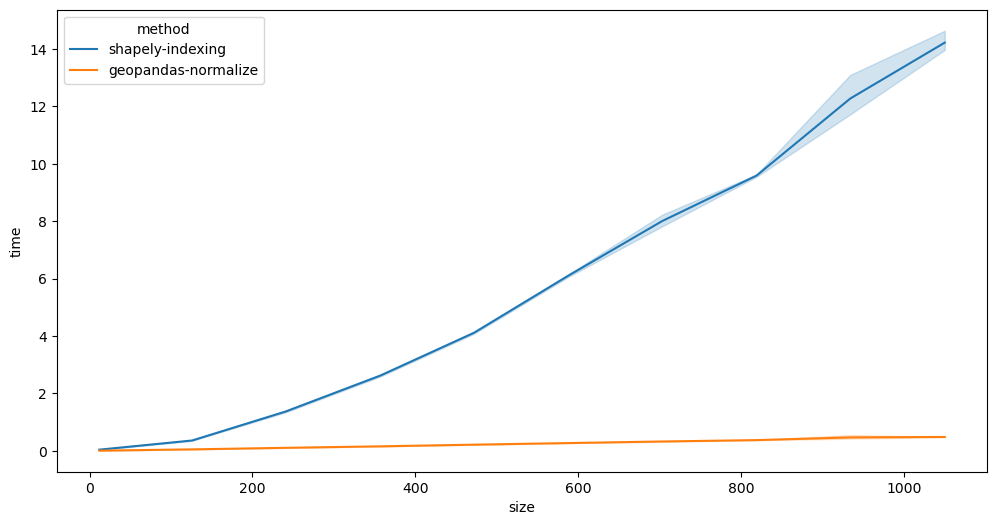

In [167]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="size", y="time", hue="method")
plt.show()